In [1]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/Jbremy/Dropbox/INF554_M1_Machine_Learning_I/2019/labs/lab3_GMM/utils.py'>

In [2]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.patches import Ellipse

from utils import generate_data, plot_clusters_2d

# <center>Preambule <center>

You are provided with two functions:
```python
def generate_data(n_clusters=None, n_dim=None, n_data=None, mus=None, sigmas=None):
    """
    Generates random data with respect to the parameters provided
    Args:
        n_clusters (int): the number of clusters
        n_dim (int): data dimensionality
        n_data (int, list): total number of data (split evenly into clusters)
                            if list, number of datapoints per cluster
        mus (list): list of  means, can be ints of lists, depending on
                    dimensionality. If int for multivariate data, all
                    dimensions have same mean.
        sigmas (list): A list of variances, can be int, or matrix
    Returns:
        X (np.array): (n_data, n_dim) or (sum(n_data), n_dim)
    """
    
def plot_clusters_2d(X, mus, sigmas=None, zoom=1, fig_kwargs={}, path=None):
    """
    Args:
        X (np.array): Data
        mus (np.array): (n_clusters, n_dim) means vectors
        sigmas (np.array): (n_clusters, n_dim, n_dim) variance matrices
        zoom (float, int): if > 1 enhances the size of elipses
        path (str): if and where to save figure
    """
```

# <center>K-Means </center>

In [3]:
def K_means(X, K, T=100):
    """
    Args:
        X (np.array, np.matrix): data. (N,d)
        K (int): The number of clusters
    Returns:
        mus (np.array): means (K,d)
        S (np.array): Matrice of clusters (N,K)
    """
    updated = False
    idx = np.random.choice([_ for _ in range(X.shape[0])], size=K, replace=False)
    mus = X[idx,:]
    t=0
    while 1:
        dists = []
        for k in range(K):
            dists.append(np.linalg.norm(X-mus[k,:], axis=1).reshape(-1,1))
        dists = np.concatenate(dists, axis=1)
        S = np.zeros((X.shape[0], K))
        clusters = np.argmin(dists, axis=1)
        for i, k in enumerate(clusters):
            S[i,k-1] = 1
            
        if t < T:
            mus = S.T @ X / np.sum(S,0).reshape(-1,1)
            t += 1
        
        else:
            break

    return mus, S

<Figure size 432x288 with 0 Axes>

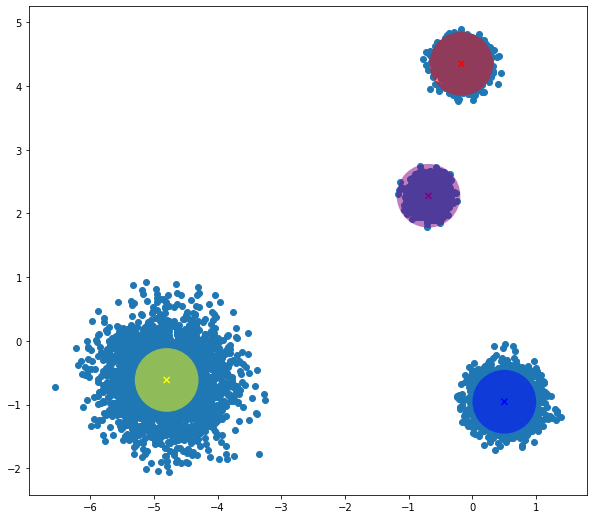

In [17]:
X = generate_data(n_clusters=4, n_dim=2, n_data=10000)
mus, S = K_means(X, 4, T=400)
plot_clusters_2d(X, mus)#, path="/Users/Jbremy/Dropbox/INF554_M1_Machine_Learning_I/2019/labs/lab3_GMM/figures/Elbow_example_data.pdf")

In [5]:
def Elbow(X, k_range, T, monte_carlo_steps):
    """
    Args:
        X (np.array, np.matrix): data. (N,d)
        k_range (int): the numbers of clusters to be tested
        T (int): Max number of steps for every k-means
        monte_carlo_steps (int): Over how many runs to average
    Returns:
        elbows (list, np.array)
    """
    
    metrix = []
    for it in range(monte_carlo_steps):
        metrix_ = []
        for k in range(1,k_range):
            mus, S = K_means(X, k, T=T)
            if not np.isnan(mus).any():
                mu = np.mean(mus*np.sum(S,0).reshape(-1,1), 0)
                metrix_.append(np.sum(np.sum(S,0).reshape(-1,1)*(mus - mu)**2).item())

            else:
                metrix_.append(metrix[len(metrix)-1][k-1])

        metrix.append(metrix_)

    elbows = np.mean(np.array(metrix), 0)
    
    return elbows

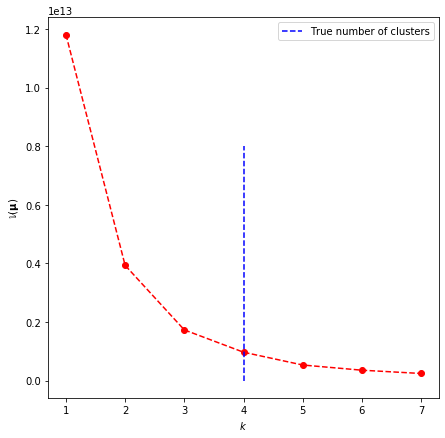

In [6]:
res = Elbow(X, 8, 40, 10)
fig = plt.figure(figsize=(7,7))
plt.plot([_ for _ in range(1,8)], res, 'o--', c='r', zorder=0)
plt.vlines(x=4, ymin=0, ymax=8e12, linestyle='--', color='b', label='True number of clusters')
plt.ylabel(r'$\mathbb{V}(\mathbf{\mu})$')
plt.xlabel(r'$k$')
plt.legend()
#plt.savefig("/Users/Jbremy/Dropbox/INF554_M1_Machine_Learning_I/2019/labs/lab3_GMM/figures/Elbow_example.pdf")
plt.show()

# Implementation of the EM-algorithm in the case of GMM

In [3]:
def norm_density(x, mu, det_sigma, inv_sigma):
    """
    Args:
        x (np.array, np.matrix): a data point
        mu (np.array): a mean vector
        det_sigma (float): determinant of variance matrix
        inv_sigma (np.matrix): inverse of variance matrix
    returns:
        (float)
    """
    ...
    deviation = np.matrix(x-mu).T
    return (1/(np.sqrt(2*np.pi)**x.size * det_sigma) * np.exp(-1/2*deviation.T @ inv_sigma @ deviation)).item()

def compute_gammas(X, pi, mus, sigmas):
    """
    Args:
        X (np.array, np.matrix): Full data (n_data, dimensions)
        pi (iterable): the probbilities associated with the clusters
        mus (np.array): mean vectors of clusters (n_clusters, dimensions)
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
    Returns:
        gammas (np.array, np.matrix): matrix of gammas product of the expectation step (n_clusters, n_data)
    """
    n_clusters = len(pi)
    # First we compute inverses and determinants, so that we don't loose computation time
    inv_sigma = []
    det_sigma = []
    for k in range(n_clusters):
        inv_sigma.append(np.linalg.inv(sigmas[k,:,:]))
        det_sigma.append(np.linalg.det(sigmas[k,:,:]))
        
    gammas = np.matrix(np.zeros(shape=(n_clusters, X.shape[0])))
    for k in range(n_clusters):
        for i in range(X.shape[0]):
            gammas[k,i] = pi[k]*norm_density(X[i,:], mus[k,:], det_sigma[k], inv_sigma[k])
            densities = np.array([norm_density(X[i,:], mus[k_,:], det_sigma[k_], inv_sigma[k_])\
                                  for k_ in range(n_clusters)])
            denominator = pi.T @ densities
            gammas[k,i] /= denominator

    return gammas

In [4]:
def pi_update(gammas_sum, n_data):
    """
    Args:
        gammas_sum (iterable): iterable containing the sum of gammas (n_clusters)
        n_data (int): number of data points
    Returns:
        pi (iterable): the updated probbilities associated with the clusters
    """
    return gammas_sum/n_data

def mu_update(gammas_sum, gammas, X):
    """
    Args:
        gammas_sum (iterable): iterable containing the sum of gammas (n_clusters)
        gammas (np.array, np.matrix): matrix of gammas product of the expectation step (n_clusters, n_data)
        X (np.array, np.matrix): Full data (n_data, dimensions)
    Returns:
        mus (np.array): updated mean vectors of clusters (n_clusters, dimensions)
    """
    return gammas @ X / gammas_sum

def sigma_update(gammas, gammas_sum, X, mus):
    """
    Args:
        gammas_sum (iterable): iterable containing the sum of gammas (n_clusters)
        gammas (np.array, np.matrix): matrix of gammas product of the expectation step (n_clusters, n_data)
        X (np.array, np.matrix): Full data (n_data, dimensions)
    Returns:
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
    """
    n_clusters = mus.shape[0]
    sigmas = np.zeros(shape=(n_clusters, X.shape[1], X.shape[1]))
    for k in range(n_clusters):
        deviations = np.matrix(X - mus[k,:])
        sigmas[k,:,:] = np.sum([gammas[k,i] * deviations[i,:].T @ deviations[i,:]\
                                        for i in range(X.shape[0])], 0) 
        sigmas[k,:,:] /= gammas_sum[k]
    
    return sigmas

In [5]:
def EM(data, n_dimensions, n_clusters, n_steps):
    """
    Args:
        data (np.array): (n_data, dimensions)
        n_dimensions (int): number of dimensions to use
        n_clusters (int)
        n_steps (int)
    Returns:
        mus (np.array): mean vectors of clusters (n_clusters, dimensions)
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
        pi (iterable): probbilities associated with the clusters
    """
    # Init X and parameters
    X = np.matrix(data[:,:n_dimensions])
    n_data = X.shape[0]
    mus = np.random.normal(0, 1, size=(n_clusters, n_dimensions))
    sigmas = np.stack([np.identity(n_dimensions)]*n_clusters)
    pi = np.random.normal(-1, 1, size=n_clusters)
    pi /= np.sum(pi)
    
    for step in range(n_steps):
        #Estimation
        gammas = compute_gammas(X, pi, mus, sigmas)
        #Maximization
        gammas_sum = np.sum(gammas, 1).reshape(-1,1)
        pi = pi_update(gammas_sum, n_data)
        sigmas = sigma_update(gammas, gammas_sum, X, mus)
        mus = mu_update(gammas_sum, gammas, X)

    return np.array(mus), sigmas, pi

# Test on a syntetic datasets

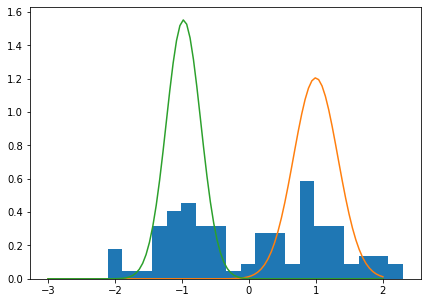

In [10]:
X = generate_data(mus=[-1,1], sigmas=[0.5,0.5], n_dim=1, n_data=100)
mus, sigmas, pi = EM(X, n_dimensions=1, n_clusters=2, n_steps=100) 

fig = plt.figure(figsize=(7,5))
plt.hist(X, 20, density=True)
x = np.linspace(-3,2,100)
plt.plot(x, stats.norm.pdf(x, mus[0].item(), sigmas[0].item()))
plt.plot(x, stats.norm.pdf(x, mus[1].item(), sigmas[1].item()))
plt.show()

<Figure size 432x288 with 0 Axes>

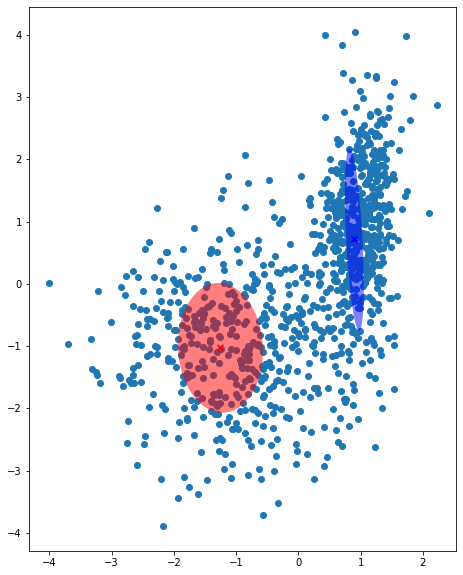

In [6]:
True_Sigma_1 = 1
True_Sigma_2 = np.matrix([[0.1, 0.09], [0.09, 1]])
X = generate_data(mus=[-1,1], sigmas=[True_Sigma_1, True_Sigma_2], 
                  n_dim=2, n_data=1000)
mus, sigmas, pi = EM(X, n_dimensions=2, n_clusters=2, n_steps=15)
plot_clusters_2d(X, mus, sigmas, zoom=2)